# Similarity Matrix

用深度学习建模句子对相似度任务时，通常有两种方式，分别是`Representation-based model`和`Interaction-based model`。前者分别将两个句子独立编码为语义向量，然后再判断句子之间的相似度；后者首先计算两个句子的相似度矩阵，再利用更复杂的模型捕获相似度特征，从而判断句子之间的相似度。

这里，我们仅考虑`Interaction-based model`最简单的形式，即两个句子分别表示成词向量，再计算句子之间的相似度矩阵。

以下是PyTorch的实现方法。

## 1. 模拟数据

以下数据取自NIPS 2011论文：[Dynamic pooling and unfolding recursive autoencoders for paraphrase detection](http://papers.nips.cc/paper/4204-dynamic-pooling-and-unfolding-recursive-autoencoders-for-paraphrase-detection.pdf)。

In [99]:
sentence_pairs_ = [
    (
        'LLEYTON Hewitt yesterday traded his tennis racquet for his first sporting passion - ' + \
          'Australian football - as the world champion relaxed before his Wimbledon title defence',
        'LLEYTON Hewitt yesterday traded his tennis racquet for his first sporting passionAustralian ' + \
          'rules football-as the world champion relaxed ahead of his Wimbledon defence'
    ),
    (
        'The lies and deceptions from Saddam have been well documented over 12 years',
        'It has been well documented over 12 years of lies and deception from Saddam'
    ),
    ('The initial report was made to Modesto Police December 28', 'It stems from a Modesto police report')
]
sentence_pairs = [[] for i in range(len(sentence_pairs_))]
max_len_1, max_len_2 = -1, -1
for i, pair in enumerate(sentence_pairs_):
    words = pair[0].split(' ')
    sentence_pairs[i].append(words)
    if len(words) > max_len_1:
        max_len_1 = len(words)
    words = pair[1].split(' ')
    sentence_pairs[i].append(words)
    if len(words) > max_len_2:
        max_len_2 = len(words)
print(max_len_1, max_len_2)  # 26 23

26 23


### 1.1 构建alphabet

In [100]:
# 构建alphabet
alphabet = dict()
index = 1
for pair in sentence_pairs:
    for word in pair[0] + pair[1]:
        if word not in alphabet:
            alphabet[word] = index
            index += 1
print(alphabet)

{'has': 43, 'traded': 4, 'Wimbledon': 21, 'defence': 23, 'for': 8, 'of': 28, 'stems': 54, '28': 53, 'years': 41, 'first': 9, 'rules': 25, 'champion': 18, 'his': 5, 'title': 22, 'Police': 51, 'as': 15, 'deception': 44, 'December': 52, 'Saddam': 34, 'LLEYTON': 1, 'Modesto': 50, 'tennis': 6, 'The': 29, 'It': 42, 'a': 55, 'yesterday': 3, 'made': 48, 'well': 37, 'documented': 38, '-': 12, 'Hewitt': 2, 'football-as': 26, 'have': 35, 'sporting': 10, '12': 40, 'ahead': 27, 'before': 20, 'from': 33, 'report': 46, 'over': 39, 'relaxed': 19, 'Australian': 13, 'the': 16, 'football': 14, 'been': 36, 'passion': 11, 'racquet': 7, 'was': 47, 'and': 31, 'initial': 45, 'to': 49, 'deceptions': 32, 'lies': 30, 'police': 56, 'world': 17, 'passionAustralian': 24}


### 1.2 词序列转为id序列

定义将词序列转为id序列的函数：

In [101]:
def word2ids(words):
    ids = []
    for word in words:
        if word in alphabet:
            ids.append(alphabet[word])
        else:
            ids.append(0)
    return ids

将`sentence_pairs`转为词序列：

In [102]:
sentences_1 = np.zeros((len(sentence_pairs), max_len_1), dtype='int32')
sentences_2 = np.zeros((len(sentence_pairs), max_len_2), dtype='int32')

for i, pair in enumerate(sentence_pairs):
    ids = word2ids(pair[0])
    sentences_1[i][:len(ids)] = ids
    ids = word2ids(pair[1])
    sentences_2[i][:len(ids)] = ids

sentences_1 = torch.LongTensor(sentences_1)
sentences_2 = torch.LongTensor(sentences_2)

## 2. Embedding

首先加载预训练词向量，使用的是[glove（400k,50维）](https://nlp.stanford.edu/projects/glove/)，工具为gensim。

In [103]:
import gensim

word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('./data/glove.6B.50d.bin', binary=True)
print(word2vec_model.vector_size)  # 50
print(len(word2vec_model.vocab))  # 400000

50
400000


### 2.1 从预训练词向量构建embedding层权重

In [104]:
import numpy as np

embedding_weights = np.zeros((len(alphabet)+1, word2vec_model.vector_size), dtype='float32')  # shape=[57, 50]

exact_match, case_match, miss_match = 0, 0, 0 
for word in alphabet:
    if word in word2vec_model:
        embedding_weights[alphabet[word]] = word2vec_model[word]
        exact_match += 1
    elif word.lower() in word2vec_model:
        embedding_weights[alphabet[word]] = word2vec_model[word.lower()]
        case_match += 1
    else:
        miss_match += 1
print('exact match: {0}, case match: {1}, miss match: {2}'.format(exact_match, case_match, miss_match))

exact match: 44, case match: 10, miss match: 2


### 2.2 构建Embedding层

In [105]:
import torch
import torch.nn as nn

embedding = nn.Embedding(len(alphabet)+1, word2vec_model.vector_size, padding_idx=0)
embedding.weight.data.copy_(torch.FloatTensor(embedding_weights))

print(embedding)
print(embedding(sentences_1).size())  # size=[3, 26, 50]
print(embedding(sentences_2).size())  # size=[3, 23, 50]

Embedding(57, 50, padding_idx=0)
torch.Size([3, 26, 50])
torch.Size([3, 23, 50])


## 3. 计算Similarity Matrix

定义计算相似度矩阵的函数：

In [106]:
def compute_similarity_matrix(input_1, input_2):
        """获取input_1与input_2之间的余弦相似度矩阵
        Args:
            input_1: 3D tensor, size=[bs, max_len_1, input_dim]
            input_2: 3D tensor, size=[bs, max_len_2, input_dim]

        Returns:
            similarity_matrix: 3D tensor, size=[bs, max_len_1, max_len_2]
        """
        # 计算分子, size=[bs, max_len_1, max_len_2]
        similarity_part_1 = torch.bmm(
            input_1, torch.transpose(input_2, 2, 1).contiguous())

        # 计算分母
        input_sqrt_sum_pow_1 = torch.sqrt(
            torch.sum(torch.pow(input_1, 2), -1)).unsqueeze(-1)  # [bs, max_len_1, 1]
        input_sqrt_sum_pow_2 = torch.sqrt(
            torch.sum(torch.pow(input_2, 2), -1)).unsqueeze(-2)  # [bs, 1, max_len_2]
        similarity_part_2 = torch.bmm(
            input_sqrt_sum_pow_1, input_sqrt_sum_pow_2)  # [bs, max_len_1, max_len_2]

        # 计算cosine similarity，需要考虑除0的情况，防止出现`nan`
        return similarity_part_1 / (similarity_part_2 + 1.e-8)

将id序列转换为embedding形式，并计算相似度矩阵：

In [107]:
input_1 = embedding(sentences_1)
input_2 = embedding(sentences_2)

similarity_matrix = compute_similarity_matrix(input_1, input_2)
print(similarity_matrix.size())  # size=[3, 26, 23]

torch.Size([3, 26, 23])


similarity_matrix[i][j][k]即表示第i对句子中，句子1中的地j个词与句子2中的第k个词之间的余弦相似度。

## 4. 可视化

最后，可以利用matplotlib库将相似度矩阵可视化：

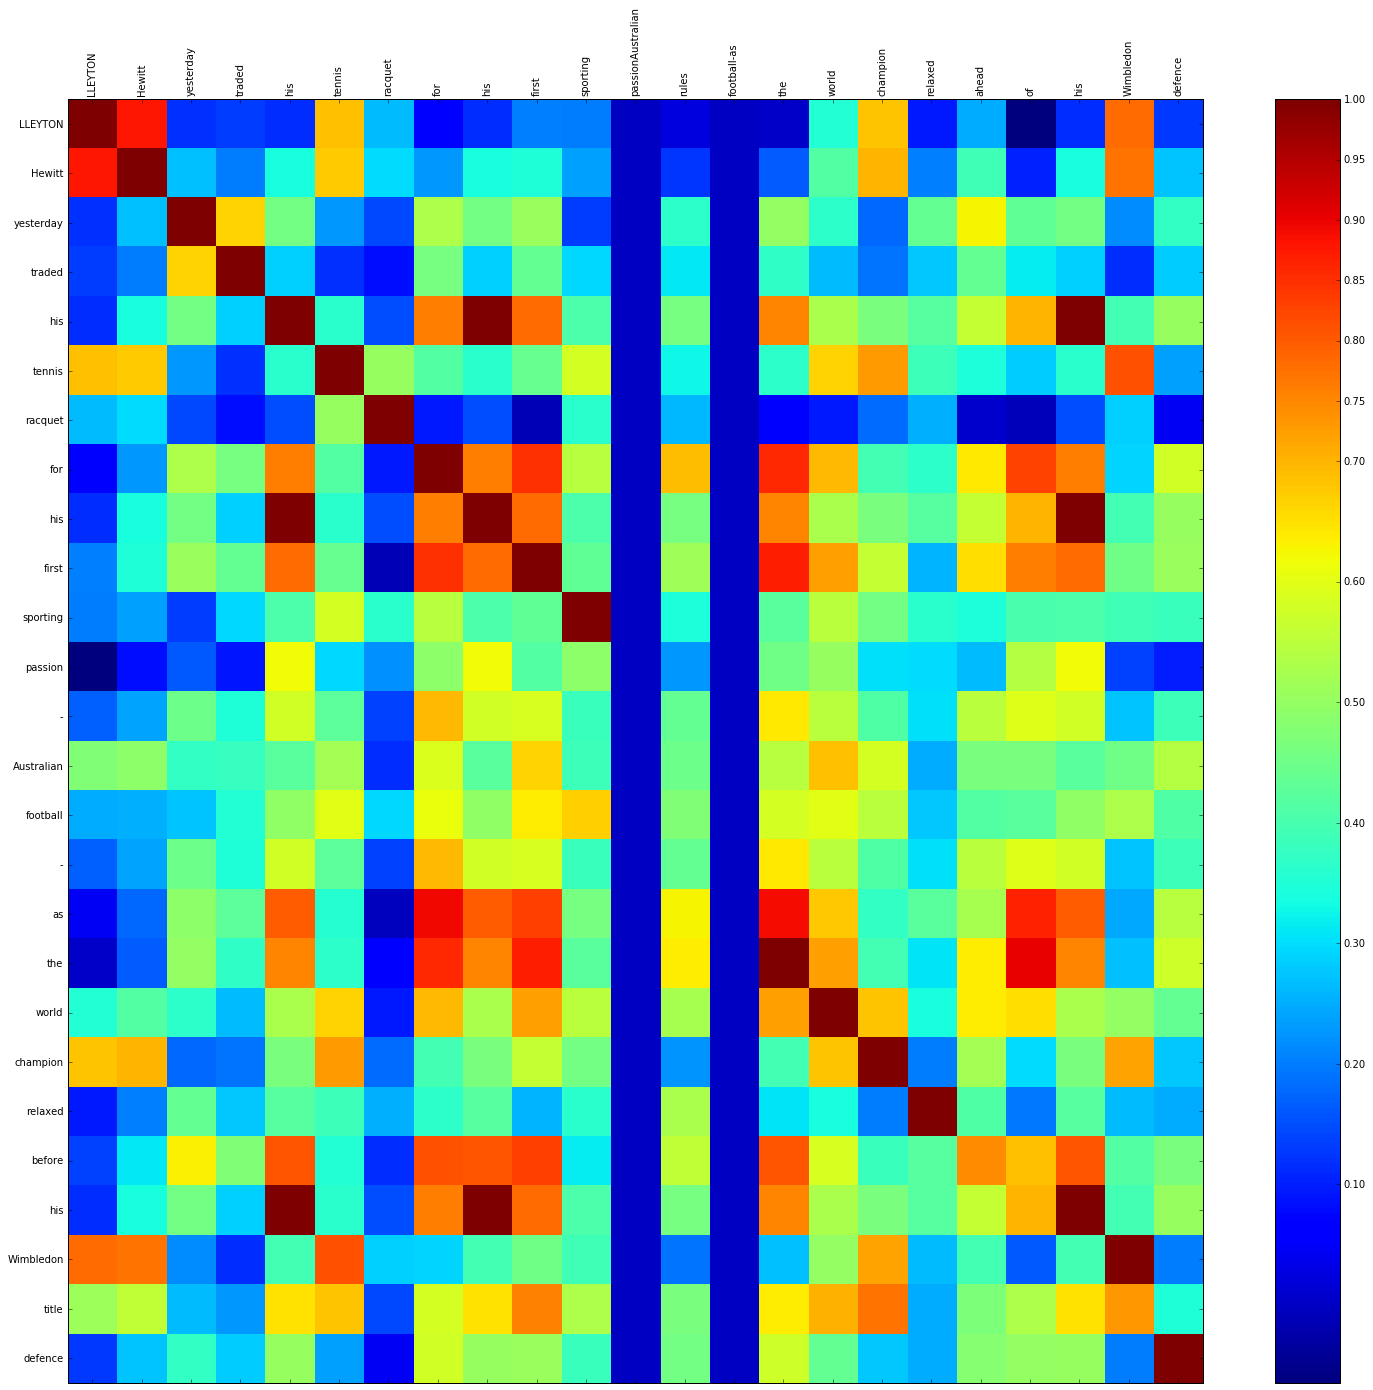

In [97]:
import matplotlib.pyplot as plt
from matplotlib import cm as cm

sent_idx = 0
fig, ax = plt.subplots(figsize=(max_len_1,max_len_2))
# cmap = cm.get_cmap('Greens')
cax = ax.matshow(similarity_matrix[sent_idx].data, interpolation='nearest', cmap=None)
plt.xticks(range(max_len_2), sentence_pairs[sent_idx][1], rotation=90)
plt.yticks(range(max_len_1), sentence_pairs[sent_idx][0])
fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])

图中，颜色越红表示相似度越高，颜色越蓝表示相似度越低，可以看出对角线附近出现很多深红色的方块。另外，在`passionAustralian`和`football-as`这两列为全蓝，这是因为这两个词是未登录词，我们在上文将未登录词的词向量初始化为全0，所以未登录词与任何词的余弦相似度都是很小的值。